In [20]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

**Notebook contains comparisons between initial models using various metrics. Also contains code at bottom showing timeseries where the TFT performs badly**

In [21]:
#data processed
main_dataset = pd.read_csv("../data/data_processed_plant_item_new_vars_15_03_22.csv")

In [22]:
# Load data from Tensors
#TFT_dual_predictions = np.load('../data/model_preds/dual_TFT_preds.npy', allow_pickle=True)
TFT_predictions = np.load('../data/model_preds/TFT_predictions_17_03_22.npy', allow_pickle=True)
naive_predictions = np.load('../data/model_preds/naive_predictions.npy', allow_pickle=True)
ARIMA_predictions = np.load('../data/model_preds/ARIMA_predictions.npy', allow_pickle=True)
actual = np.load('../data/model_preds/actual_sales.npy', allow_pickle=True)

In [23]:
print(main_dataset.columns.values)

['Unnamed: 0' 'index' 'ParentItemID' 'PlantID' 'Volume' 'Date' 'SAG1'
 'SAG2' 'SAG3' 'SAG4' 'Quality' 'RimSize' 'Season' 'SpeedIndex'
 'UHPNonUHPIndicator' 'time_idx' 'month' 'log_volume' 'log_ret'
 'avg_volume_by_material' 'max_volume_by_material'
 'min_volume_by_material' 'std_volume_by_material' 'avg_volume_by_plant'
 'max_volume_by_plant' 'min_volume_by_plant' 'std_volume_by_plant'
 'timeseries' 'index.1' 'encoding_1' 'encoding_2' 'encoding_3']


# Baseline Error Performance

In order to compare model perofrmance we need an estimate of bayes limit for the problem. In this case we do not have a human error reference. So we use the the lowest of the following:
- APO recorded forecast. This is the collection of models used by the sales team (when we receive it that is)
- Persistance 1 month. Using the observed values from the previous months as the prediction of the next month. This is the Naive Forecast
- Persistance 3 month mean. Using the observations from the previous 3 months as the prediction of the next month.

By establishing a baseline error we have a refernce to compare our training and validation set performance. This guides us to understand where and how a model is performance. For example, if our bayes error is MAE 5% and our model training and validation perform at MAE 6% and 9% respectively then the relevant obserevation is that our model performs with high variance with respect to the baseline. The contrary is true if we consider baseline, train, and validation MAEs of 5%, 8%, and 8.5% respectively. In the latter case we should work on the bias of the training set before considering the validation performance (low variance).

In [24]:
main_dataset['perisitence_1'] = main_dataset['Volume'].shift(1)
main_dataset['perisitence_2'] = main_dataset['Volume'].shift(2)
main_dataset['perisitence_3'] = main_dataset['Volume'].shift(3)
main_dataset['perisitence_3_mean'] = (main_dataset['perisitence_1'] + main_dataset['perisitence_2'] + main_dataset['perisitence_3']) / 3 

In [25]:
########ADDED#########
def update_perisitence_3_mean_forecast(data):
    for i in range(35, data.shape[0], 35):
        true_pred = float(data['perisitence_3_mean'].iloc[i - 7])
        data['perisitence_3_mean'].iloc[i - 6:i] = true_pred
    return data

In [26]:
# Filter by relevant Timesteps for predictions that have been made
subset_of_main_data = main_dataset[['ParentItemID', 'PlantID', 'time_idx', 'timeseries', 'Volume', 'perisitence_3_mean']]
subset_of_main_data = update_perisitence_3_mean_forecast(subset_of_main_data)
subset_of_main_data = subset_of_main_data[subset_of_main_data['time_idx'].isin([29, 30, 31, 32, 33, 34])]
subset_of_main_data = subset_of_main_data.reset_index()

# Add in the datasets from Tensors
subset_of_main_data['actuals_output'] = np.array(actual).flatten()
subset_of_main_data['naive_predictions'] = np.array(naive_predictions).flatten()
subset_of_main_data['ARIMA_predictions'] = np.array(ARIMA_predictions).flatten()
subset_of_main_data['TFT_predictions'] = np.array(TFT_predictions).flatten()
#subset_of_main_data['dual_TFT_predictions'] = np.array(TFT_dual_predictions).flatten()

# Check that Actual is done properly
print(f"The difference between Actual Output and Original is:  {(subset_of_main_data['actuals_output'] - subset_of_main_data['Volume']).sum()}")

# Check for NaN's in Dataset. If there were nans, we would fill nans with linear interpolation because this is how we will fill when using the data in the models.
if sum(list(main_dataset.isna().sum())) > 0:
  print('\033[93m You have NaN\'s in your main_dataset dataset')

if sum(list(subset_of_main_data.isna().sum())) > 0:
  print('\033[93m You have NaN\'s in your subset_of_main_data dataset')


C:\Users\Joseph.Amess\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


The difference between Actual Output and Original is:  0.0
 You have NaN's in your main_dataset dataset


In [27]:
#Aggregate by item since this is how APO tests their forecasts
aggregate = subset_of_main_data.groupby(['ParentItemID', 'time_idx'], as_index=False).agg('sum')
aggregate.drop(['index', 'timeseries'], axis=1, inplace=True)

In [28]:
print(aggregate.head())

        ParentItemID  time_idx  Volume  perisitence_3_mean  actuals_output  \
0  AI19565015TWICA22        29     203                72.0           203.0   
1  AI19565015TWICA22        30      40                72.0            40.0   
2  AI19565015TWICA22        31      56                72.0            56.0   
3  AI19565015TWICA22        32      15                72.0            15.0   
4  AI19565015TWICA22        33      82                72.0            82.0   

   naive_predictions  ARIMA_predictions  TFT_predictions  
0              400.0         428.307860       389.046021  
1              400.0         446.839396       230.672394  
2              400.0         442.624812       237.625641  
3              400.0         439.978209       420.085968  
4              400.0         433.712669       135.854141  


In [29]:
subset_of_main_data.columns

Index(['index', 'ParentItemID', 'PlantID', 'time_idx', 'timeseries', 'Volume',
       'perisitence_3_mean', 'actuals_output', 'naive_predictions',
       'ARIMA_predictions', 'TFT_predictions'],
      dtype='object')

In [30]:
print(subset_of_main_data.head())

   index       ParentItemID PlantID  time_idx  timeseries  Volume  \
0     29  AI19565015TWICA22    5M01        29          80     203   
1     30  AI19565015TWICA22    5M01        30          80       0   
2     31  AI19565015TWICA22    5M01        31          80       0   
3     32  AI19565015TWICA22    5M01        32          80       0   
4     33  AI19565015TWICA22    5M01        33          80       0   

   perisitence_3_mean  actuals_output  naive_predictions  ARIMA_predictions  \
0           66.666667           203.0              328.0         333.935325   
1           66.666667             0.0              328.0         354.508557   
2           66.666667             0.0              328.0         349.960162   
3           66.666667             0.0              328.0         352.019790   
4           66.666667             0.0              328.0         353.201735   

   TFT_predictions  
0       244.250031  
1       122.789307  
2       150.732849  
3       269.368896  
4    

In [31]:
def MAE(dataset, forecast):
  return tf.keras.losses.MAE(dataset["Volume"], dataset[forecast]).numpy()

In [32]:
def WMAPE(dataset, forecast):
  WMAPE_output = (( abs(  dataset[forecast] - dataset['actuals_output']  ) ).sum() / dataset['actuals_output'].sum()) * 100
  return WMAPE_output

In [33]:
list_of_forecasts = [
                    #  'APO_forecast', 'SalesHead_Corr_Forecast', 
                     'naive_predictions', 
                     'perisitence_3_mean', 
                     'actuals_output', 'ARIMA_predictions', 'TFT_predictions']

ref_error = pd.DataFrame({
    "Method": list_of_forecasts,
    "MAE": [
            MAE(subset_of_main_data, list_of_forecasts[0]),
            MAE(subset_of_main_data, list_of_forecasts[1]),
            MAE(subset_of_main_data, list_of_forecasts[2]),
            MAE(subset_of_main_data, list_of_forecasts[3]),
            #MAE(subset_of_main_data, list_of_forecasts[4]),
            MAE(subset_of_main_data, list_of_forecasts[4])],
    "WMAPE":[
            WMAPE(subset_of_main_data, list_of_forecasts[0]),
            WMAPE(subset_of_main_data, list_of_forecasts[1]),
            WMAPE(subset_of_main_data, list_of_forecasts[2]),
            WMAPE(subset_of_main_data, list_of_forecasts[3]),
            #WMAPE(subset_of_main_data, list_of_forecasts[4]),
            WMAPE(subset_of_main_data, list_of_forecasts[4])],
     "Aggregated WMAPE":[
            WMAPE(aggregate, list_of_forecasts[0]),
            WMAPE(aggregate, list_of_forecasts[1]),
            WMAPE(aggregate, list_of_forecasts[2]),
            WMAPE(aggregate, list_of_forecasts[3]),
            #WMAPE(aggregate, list_of_forecasts[4]),
            WMAPE(aggregate, list_of_forecasts[4])]       }, 
    index=[i for i in range(len(list_of_forecasts))])

In [34]:
cell_hover = {  # for row hover use <tr> instead of <td>
    'selector': 'td:hover',
    'props': [('background-color', 'white'), ('color', 'black')]
}
index_names = {
    'selector': '.index_name',
    'props': 'font-style: italic; color: darkgrey; font-weight:normal;'
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #8900f2; color: white;'
}

def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

def highlight_compare(s, props=''):
    return np.where(s > s[0], props, '')

def highlight_compare2(s, props=''):
    return np.where(s < s[0], props, '')


s = ref_error.style
s = s.set_table_styles([cell_hover, index_names, headers])

# DataFrame maximum in red, and column maximums in orange.

s.apply(highlight_max, props='color:white;background-color:orange;', subset=pd.IndexSlice[:, ['MAE', 'WMAPE', 'Aggregated WMAPE']], axis=0)\
  .apply(highlight_max, props='color:white;background-color:red', subset=pd.IndexSlice[:, ['MAE', 'WMAPE', 'Aggregated WMAPE']], axis=None)\
  .apply(highlight_compare, props='color:#961c00;',subset=pd.IndexSlice[:, ['MAE', 'WMAPE', 'Aggregated WMAPE']], axis=0)\
  .apply(highlight_compare2, props='color:green;',subset=pd.IndexSlice[:, ['MAE', 'WMAPE', 'Aggregated WMAPE']], axis=0)\
  .set_properties(**{'background-color': '#8900f2', 'font-weight':'bold'}, subset=pd.IndexSlice[:, ['Method']])

print('DataFrame maximum in red, and column maximums in orange. If metric is larger than Naive i.e.[0] for that metric, text is dark red. Otherwise, it is green.')
print('\033[93m Summary of errors:')
s

DataFrame maximum in red, and column maximums in orange. If metric is larger than Naive i.e.[0] for that metric, text is dark red. Otherwise, it is green.
 Summary of errors:


,Method,MAE,WMAPE,Aggregated WMAPE
0,naive_predictions,40.568352,84.304947,62.370169
1,perisitence_3_mean,43.474101,90.343377,79.554415
2,actuals_output,0.000000,0.000000,0.000000
3,ARIMA_predictions,38.716288,80.456181,60.125219
4,TFT_predictions,34.355984,71.395039,57.352497


In [40]:
#Get WMAPE for each month prediction
def monthly_performance(data, list_of_forecasts):
    time_indices = list(data.time_idx.unique())
    monthly_performance_df = pd.DataFrame(np.zeros((len(time_indices), len(list_of_forecasts) + 1)), columns=['month'] + list_of_forecasts)
    for month in time_indices:
        monthly_performance_df.iloc[month - 29, 0] = month
        for i in range(0, len(list_of_forecasts)):
            forecast = list_of_forecasts[i]
            month_data = data[data['time_idx'] == month]
            WMAPE_output = WMAPE(month_data, forecast)
            monthly_performance_df.iloc[month - 29, i + 1] = WMAPE_output
    return monthly_performance_df

In [41]:
perf_df = monthly_performance(aggregate, list_of_forecasts)

In [42]:
print(perf_df)

   month  naive_predictions  perisitence_3_mean  actuals_output  \
0   29.0          54.103653           68.995433             0.0   
1   30.0          55.385520           72.277293             0.0   
2   31.0          54.768460           72.884478             0.0   
3   32.0          63.869130           83.318839             0.0   
4   33.0          68.020420           87.413185             0.0   
5   34.0          80.438055           92.479264             0.0   

   ARIMA_predictions  TFT_predictions  
0          52.307237        44.222004  
1          52.056690        54.775535  
2          55.756786        55.223720  
3          63.629271        55.200258  
4          64.582012        69.514138  
5          72.822621        64.845077  


In [43]:
perf_df.columns

Index(['month', 'naive_predictions', 'perisitence_3_mean', 'actuals_output',
       'ARIMA_predictions', 'TFT_predictions'],
      dtype='object')

naive_predictions
perisitence_3_mean
actuals_output
ARIMA_predictions
TFT_predictions


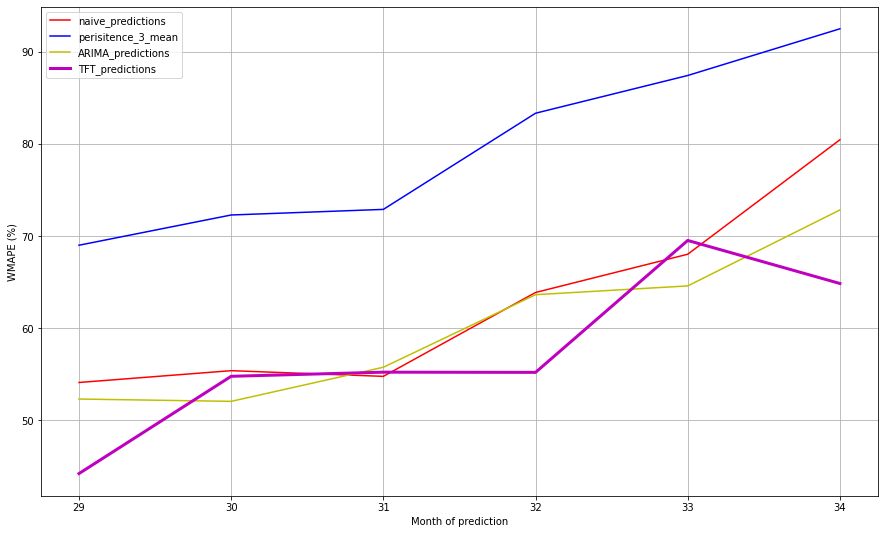

In [45]:
def colour_dict_creator(list_of_forecasts):
    colour_dict = {}
    colour_list = ['r', 'b', 'g', 'y', 'm', 'c', 'k']
    for i in range(len(list_of_forecasts)):
        colour_dict[list_of_forecasts[i]] = colour_list[i]
    return colour_dict


def performance_plotter(data):
    colour_dict = colour_dict_creator(list_of_forecasts)
    plt.figure(figsize=(15, 9))
    plt.grid()
    for forecast in list(data.columns.values)[1::]:
        print(forecast)
        if forecast == 'actuals_output':
            continue
        if forecast == 'multi_TFT_predictions':
            continue
        if forecast == 'TFT_predictions':
            plt.plot(data['month'], data[forecast], label=forecast, c=colour_dict[forecast], linewidth=3)
            continue
        plt.plot(data['month'], data[forecast], label=forecast, c=colour_dict[forecast])
    plt.ylabel('WMAPE (%)')
    plt.xlabel('Month of prediction')
    plt.legend()
    plt.show()


performance_plotter(perf_df)

**Replace naive and TFT predictions with singular monthly predictions with past data as a shifting window over the last 30 months to test performance one month ahead**

In [46]:
#Load month vectors and create array
def pred_array_builder(actual, dir_start, dir_middle, months, dir_end):
    pred_array = np.zeros((actual.shape[0], actual.shape[1]))
    for i in range(len(months)):
        full_dir = dir_start + dir_middle + months[i] + dir_end
        month_preds = np.load(full_dir, allow_pickle=True)
        pred_array[:, i] = np.squeeze(month_preds)
    return pred_array


dir_start = '../data/model_preds/single_month_preds/'
dir_middle = 'TFT_predictions'
months = ['_month1', '_month2', '_month3', '_month4', '_month5', '_month6']
dir_end = '.npy'
dir_middle = 'TFT_predictions'
TFT_predictions = pred_array_builder(actual, dir_start, dir_middle, months, dir_end)
dir_middle = 'naive_predictions'
naive_predictions = pred_array_builder(actual, dir_start, dir_middle, months, dir_end)

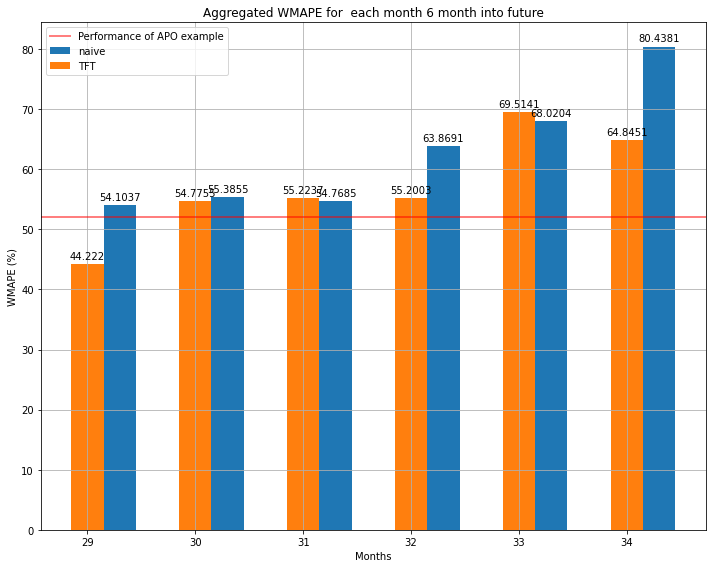

In [48]:
def plot_monthly_performance(df):
    plt.figure(figsize=(10, 8))
    plt.title('Aggregated WMAPE for  each month 6 month into future')
    w = 0.3
    plt.grid()
    bar1 = plt.bar(df['month'] + w, df['naive_predictions'], w, label='naive')
    bar2 = plt.bar(df['month'], df['TFT_predictions'], w, label='TFT')
    #bar3 = plt.bar(df['month'] - w, avg_jumps, w, label='pct of zeros in sales month')
    plt.xlabel('Months')
    plt.ylabel('WMAPE (%)')
    plt.tight_layout()
    plt.bar_label(bar1, padding=3)
    plt.bar_label(bar2, padding=3)
    #plt.bar_label(bar3, padding=3)
    plt.axhline(52, color='red', lw=2, alpha=0.5, label='Performance of APO example')
    plt.legend()
    plt.show()


plot_monthly_performance(perf_df)

In [49]:
#Function picks out WMAPE of models higher or lower than a certain threshold
def assess_worst_performers(data_full, data_subset, threshold, model_choice):
    total_vol = np.sum(data_subset['actuals_output'])
    ts_wmapes_dict = {}
    ts_list = list(data_subset.timeseries.unique())
    for i in range(len(ts_list)):
        ts = data_subset[data_subset.timeseries == ts_list[i]]
        wmape = ((abs(ts[model_choice] - ts['actuals_output'])).sum() / total_vol) * 100
        #Switch logical operator to > to see timeseries where model performs worse than threshold WMAPE
        if wmape < threshold:
            ts_wmapes_dict[ts_list[i]] = wmape
    data_worst_perfs = data_full[data_full.timeseries.isin(list(ts_wmapes_dict.keys()))]
    data_subset_worst_perfs = data_subset[data_subset.timeseries.isin(list(ts_wmapes_dict.keys()))]
    print(data_worst_perfs.shape[0] / 35)
    return data_worst_perfs, data_subset_worst_perfs

#Alter threshold to get more or less timeseries
threshold = 0.0003
#Chose model
MODEL_CHOICE = 'TFT_predictions'
data_worst_perfs, data_subset_worst_perfs = assess_worst_performers(main_dataset, subset_of_main_data, threshold, MODEL_CHOICE)

4002.0


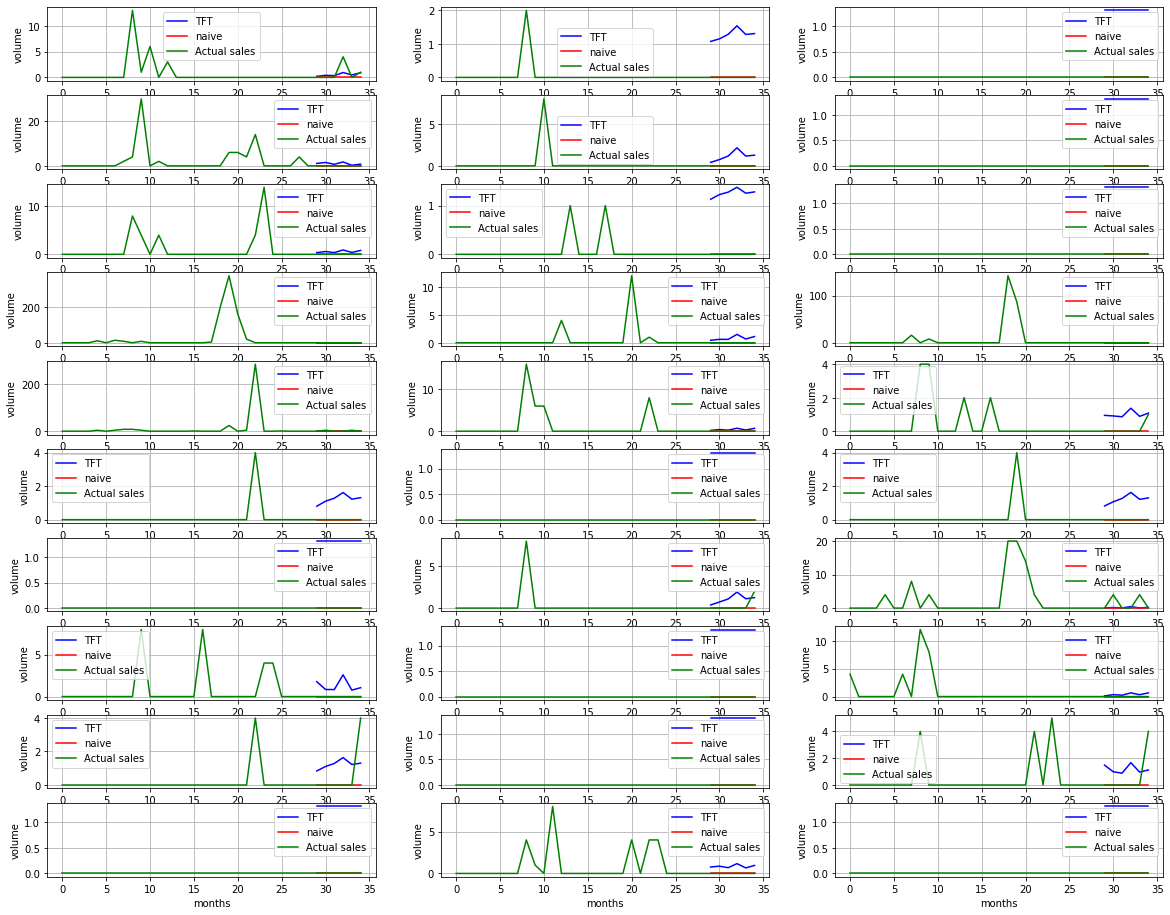

In [51]:
#Function plots first 30 predictions from data above or below threshold
def plot_preds(data_full, data_subset):
    ts_list = list(data_worst_perfs.timeseries.unique())
    fig, axs = plt.subplots(10, 3, figsize=(20, 16))
    x_ax = 0
    y_ax = 0
    for i in range(min(30, len(ts_list))):
        ts_preds = data_subset[data_subset.timeseries == ts_list[i]]
        ts_past = data_full[data_full.timeseries == ts_list[i]]
        axs[x_ax, y_ax].plot(ts_preds.time_idx, ts_preds.TFT_predictions, c='b', label='TFT')
        axs[x_ax, y_ax].plot(ts_preds.time_idx, ts_preds.naive_predictions, c='r', label='naive')
        axs[x_ax, y_ax].plot(ts_past.time_idx, ts_past.Volume, c='g', label='Actual sales')
        axs[x_ax, y_ax].grid()
        axs[x_ax, y_ax].legend()
        x_ax += 1
        if x_ax == 10:
            y_ax += 1
            x_ax = 0
    for ax in axs.flat:
        ax.set(xlabel='months', ylabel='volume')
    plt.show()

        

plot_preds(data_worst_perfs, data_subset_worst_perfs)

In [52]:
#Get average preds and actual sales for predictions above or below threshold WMAPE
def average_past_vols_calc(data):
    mean_actual_vol = data.groupby('time_idx', as_index=False).mean()[['time_idx', 'Volume']]
    return mean_actual_vol


def average_preds_calc(data, model):
    mean_preds = data.groupby('time_idx', as_index=False).mean()[['time_idx', model]]
    return mean_preds


average_actual_vols = average_past_vols_calc(data_worst_perfs)
model = 'TFT_predictions'
average_preds_TFT = average_preds_calc(data_subset_worst_perfs, model)
model = 'naive_predictions'
average_preds_naive = average_preds_calc(data_subset_worst_perfs, model)

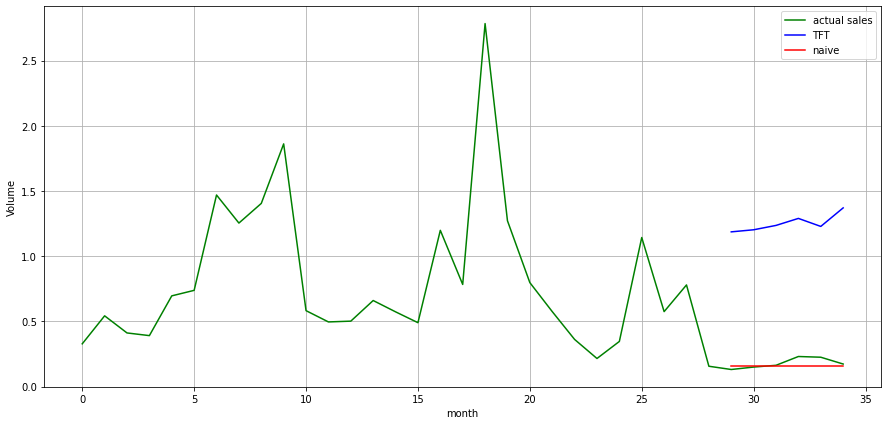

In [53]:
plt.figure(figsize=(15, 7))
plt.grid()
plt.plot(average_actual_vols['time_idx'], average_actual_vols['Volume'], c='g', label='actual sales')
plt.plot(average_preds_TFT['time_idx'], average_preds_TFT['TFT_predictions'], c='b', label='TFT')
plt.plot(average_preds_naive['time_idx'], average_preds_naive['naive_predictions'], c='r', label='naive')
plt.xlabel('month')
plt.ylabel('Volume')
plt.legend()
plt.show()